## DESNs para Equalização Cega

In [54]:
""" Importando as bibliotecas necessárias """

import numpy as np
import math
from numpy.linalg import pinv, eigvals, inv
from scipy import linalg
from scipy.linalg import toeplitz
from scipy.signal import lfilter,lfiltic
from matplotlib import cm
from scipy.spatial import distance
from sklearn.metrics import mean_squared_error as mse
import matplotlib.pyplot as plt
import pandas as pd

In [55]:
class DeepESN:
    
    """ Inicialização de um objeto da classe DeepESN 
    
    Parâmetros: num_neuronios = número de neurônios por reservatório
                num_camadas =  número de camadas da rede (num_camadas >= 1)
                leaky_values = lista com os coeficientes de vazamento de cada camada
                spectral_radii = lista com os raios espectrais de cada camada
                scale_in = valor absoluto máximo aceito para os pesos de entrada
    """
    def __init__(self,num_neuronios,num_camadas,leaky_values,spectral_radii,scale_in):
        self.N = num_neuronios
        self.Nl = num_camadas
        self.a = leaky_values
        self.rho = spectral_radii
        self.win_max = scale_in
        
    """ Método fit: 
          * constrói as matrizes aleatórias do reservatório
          * computa a matriz com os estados da rede
          * obtém a matriz de pesos de saída através da solução de quadrados mínimos (pseudo-inversa)

          Parâmetros: u - matriz com os atributos de entrada de todos os padrões de treinamento (K x T + Tr)
                      d - matriz com as saídas desejadas (L x T)
                      Tr - número de amostras para o transitório (inicializar o vetor de estado)
    """

    def fit(self,u,d,Tr):

        
        #extrai o número de atributos de entrada e o número de padrões do conjunto de treinamento (com transitório)
        self.K,self.Tt = u.shape
        
        #número de padrões efetivos do conjunto de treinamento
        self.T = self.Tt - Tr
        
        #extrai o número de saídas da rede
        self.L = d.shape[0]
        
        """ Para cada camada l (de 1 a Nl), devemos determinar (1) a matriz de pesos de entrada (aleatória),
        (2) a matriz de pesos recorrentes, respeitando a condição de estados de eco, e (3) o vetor de estados (para
        todos os instantes de tempo) 
        Por simplicidade, vamos guardar estas informações em filas de comprimento Nl 
        """
        
        #inicializa as listas que vão guardar as matrizes de pesos Win, W
        self.Win = []
        self.W = []
        #inicializa a lista que vai guardar as matrizes com os estados de cada reservatório (para todos os instantes)
        self.X = []
        self.state = []
        #inicializa a matriz que contém a concatenação dos estados dos reservatórios
        self.Xvec = np.zeros((self.N*self.Nl,self.T))
        
        for l in range(0,self.Nl):
            
            #inicializa a matriz com os estados do l-ésimo reservatório
            x_l = np.zeros((self.N,self.Tt+1))
            
            #número de entradas do reservatório l
            if (l == 0):
                Ne_l = self.K
                U = u
            else:
                Ne_l = self.N
                #a entrada da l-ésima camada é o vetor de saída da (l-1)-ésima camada (excluindo o estado inicial)
                U = np.delete(self.X[l-1],0,1)
            
            #matriz de pesos de entrada (Win) do reservatório l: N x Ne
            Win_l = 2*self.win_max*np.random.rand(self.N,Ne_l) - self.win_max
            self.Win.append(Win_l)
            
            #matriz de pesos recorrentes do reservatório l
        
            W_l = 2*np.random.rand(self.N,self.N) - 1
            Ws = (1-self.a[l])*np.eye(self.N) + self.a[l]*W_l
            max_v = max(abs(eigvals(Ws)))
            Ws = (self.rho[l]/max_v)*Ws
            W_l = (1/self.a[l])*(Ws - (1-self.a[l])*np.eye(self.N))
            self.W.append(W_l)
            
            #computa o estado do reservatório l para todos os instantes do conjunto de treinamento
            for i in range(0,self.Tt):
                
                x_l[:,i+1] = (1-self.a[l])*x_l[:,i] + self.a[l]*np.tanh(np.matmul(self.Win[l],U[:,i]) + np.matmul(self.W[l],x_l[:,i]))
                
            self.X.append(x_l)
            #coloca o estado final do reservatório l na lista chamada state
            self.state.append(np.reshape(x_l[:,self.Tt],(self.N,1)))
            
        for l in range(0,self.Nl):
            
            aux = self.X[l]
            """ elimina a primeira coluna (estado inicial com zeros) e os primeiros Tr estados (transitório)
                concatena a matriz de estados do reservatório l ao repositório completo """
            self.Xvec[l*self.N:(l+1)*self.N,:] = aux[:,Tr+1:]
        
        """ Agora, basta computar a pseudo-inversa da matriz Xvec para determinar os pesos da camada de saída """        
        self.Wout = np.matmul(pinv(self.Xvec.T),d[0,Tr:].T)
        self.Wout = self.Wout.T

        #saídas da rede para o conjunto de treinamento
        self.ytr = np.matmul(self.Wout,self.Xvec)
        
        return


    """ Método predict 
    
        Obtém as saídas da DeepESN para o conjunto de teste; as matrizes de pesos já estão prontas
    
    """
    def predict(self,ut,dt,Tr):
        
        #extrai o número de padrões do conjunto de teste
        self.nt = ut.shape[1]
        
        #inicializa a matriz com os estados concatenados (partimos do último estado observado no treinamento)
        self.Xvec_teste = np.zeros((self.N*self.Nl,self.nt-Tr))
        
        #inicializa a lista que vai guardar as matrizes com os estados de cada reservatório (para todos os instantes de teste)
        self.X_teste = []
        
        for l in range(0,self.Nl):
            
            #inicializa a matriz com os estados do l-ésimo reservatório (o estado inicial equivale ao último do treinamento)
            x_l = np.zeros((self.N,self.nt+1))
            Xl_aux = self.X[l]
            x_l[:,0] = Xl_aux[:,-1]
            
            if (l == 0):
                U = ut
            else:
                #a entrada da l-ésima camada é o vetor de saída da (l-1)-ésima camada (excluindo o estado inicial)
                U = self.X_teste[l-1]
            
            #computa o estado do reservatório l para todos os instantes do conjunto de teste
            for i in range(0,self.nt):
                
                x_l[:,i+1] = (1-self.a[l])*x_l[:,i] + self.a[l]*np.tanh(np.matmul(self.Win[l],U[:,i]) + np.matmul(self.W[l],x_l[:,i]))
                    
            #elimina a primeira coluna (estado inicial com zeros) 
            xt = np.delete(x_l,0,1)
            self.X_teste.append(xt)
        
        for l in range(0,self.Nl):
            #elimina os primeiros Tr estados (transitório)
            Xaux = self.X_teste[l]
            xt = np.delete(Xaux,np.arange(Tr),1)
            self.Xvec_teste[l*self.N:(l+1)*self.N,:] = xt
            
        #gera as saídas para o conjunto de teste
        self.yteste = np.matmul(self.Wout,self.Xvec_teste)

        return 


    """ Método one_step 
    
        Atualiza o vetor de estados da rede para a nova entrada e obtém a nova resposta da DeepESN
        Útil para o cálculo da BER
    
    """
    def one_step(self,u):
        
        #inicializa a matriz com os estados concatenados (partimos do último estado observado no treinamento)
        Xvec_teste = np.zeros((self.N*self.Nl,1))
        
        for l in range(0,self.Nl):
            
            #parte do último vetor de estados do l-ésimo reservatório
            x_l = self.state[l]
            
            if (l == 0):
                U = u
            else:
                #a entrada da l-ésima camada é o vetor de saída da (l-1)-ésima camada (excluindo o estado inicial)
                U = self.state[l-1]
            
            #computa o estado do reservatório l em resposta à entrada u
            x_l = (1-self.a.item(l))*x_l + self.a.item(l)*np.tanh(np.matmul(self.Win[l],U) + np.matmul(self.W[l],x_l))
            self.state[l] = x_l
            Xvec_teste[l*self.N:(l+1)*self.N,:] = x_l
            
        #gera a saída da rede
        self.ys = np.matmul(self.Wout,Xvec_teste)
        
        return

In [68]:
""" Rotina que gera os dados do problema de equalização cega para um FEP progressivo a passo unitário

Entrada: canal - vetor com os coeficientes que definem a função de transf. do canal
               - Ex.: H(z) = 1.6 + z^{-1} --> canal = [1.6 1]
         SNR   - relação sinal-ruído em dB
         K     - número de amostras (atual e versões atrasadas) apresentadas na entrada da rede
         T - número total de amostras válidas do conjunto
Saída:   Y - vetor linha com as amostras desejadas para a saída da rede (1 x T)
         X - matriz (dimensão K x T) com as K amostras de entrada em cada instante de tempo 
         
"""

def dados_equalizacao_cega(h,SNR,K,T):

    #comprimento do canal
    D = h.size
    
    #variância do ruído
    sigma2 = sum(h**2)*(10**(-SNR/10)) 
    
    #fonte BPSK
    s = np.sign(np.random.randn(1,T+D))
    
    #inicializa o sistema linear (canal) para partir de amostras válidas
    z = lfiltic(h,1,[],s[0,0:D-1])

    #sinal recebido
    saida_canal = lfilter(h,1,s[0,D-1:],-1,z)
    r = saida_canal[0] + np.sqrt(sigma2)*(np.random.randn(1,T+1))
    
    #monta a matriz de entrada de um FEP progressivo a passo unitário
    Rf = toeplitz(r[0,K::-1],r[0,K::1])
    #X = np.mat(Rf[1:,:])
    X = Rf[1:,:]
    
    #vetor de saída desejada
    Y = Rf[0,:]
    Y = np.reshape(Y,(1,Y.size))
    
    #sequência de símbolos da fonte que (idealmente) podemos recuperar no erro de predição (para o atraso 0) 
    S = s[0,D:]
    
    return (X,Y,S)


In [70]:
#número de amostras de treinamento
Ntr = 10000
#número de amostras de teste
Ntest = 10000
#número de amostras do transitório
Tr = 500

#Canal
h = np.array([0.5,1])
#Relação sinal-ruído (dB)
SNR = 30

#No. de amostras usadas para estimação do símbolo transmitido = número de entradas da rede
K = 1

#cria os dados 
Xtr,ytr,simb_tr = dados_equalizacao_cega(h,SNR,K,Ntr+Tr)
Xtest,ytest,simb_test = dados_equalizacao_cega(h,SNR,K,Ntest+Tr)


In [124]:
""" Construção de uma DeepESN """

#número de reservatórios
Nl = 2

#número de neurônios em cada reservatório
Nn = 40

#lista com os raios espectrais
rho = [0.1,0.95,0.95,0.95,0.95,0.95]

#lista com os parâmetros de vazamento (leaky)
a = [1,1,0.8,0.9,0.8,0.2]

#escala dos pesos de entrada
win_max = 1

#cria um objeto da classe DeepESN
DESN = DeepESN(Nn,Nl,a,rho,win_max)


## Treinamento e teste da DESN

In [125]:
#efetua o treinamento da rede
DESN.fit(Xtr,ytr,Tr)

#realiza o teste da rede
DESN.predict(Xtest,ytest,Tr)

MSE de Teste da Rede Completa: 0.003364
BER de Teste da Rede Completa: 0.000000


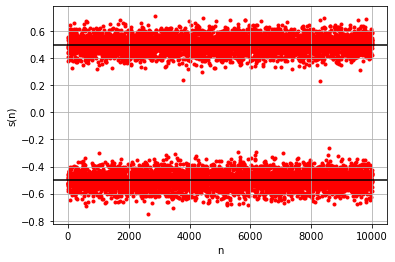

In [126]:
#erro de predição
err = ytest[0,Tr:] - DESN.yteste

#Exibe os erros de predição ao longo do tempo    
plt.figure()
plt.scatter(np.arange(1,Ntest+1),err,marker=".",c="r")
plt.axhline(y=h[0], color='k', linestyle='-')
plt.axhline(y=-h[0], color='k', linestyle='-')
plt.ylabel('e(n)')
plt.xlabel('n')
plt.grid(True)

""" Desempenho """
MSE_TESTE = mse(h[0]*simb_test[Tr:],err)
BER_TESTE = distance.hamming(simb_test[Tr:],np.sign(err/h[0]))

print("MSE de Teste da Rede Completa: %f" %MSE_TESTE)
print("BER de Teste da Rede Completa: %f" %BER_TESTE)
